In [1]:
#!apt-get update
#!apt-get install -y python3-dev graphviz libgraphviz-dev pkg-config
#!apt-get install -y latexmk
#!apt-get install -y texlive-latex-extra
#!apt-get install -y texlive-science
#%pip install -qU langchain-openai
#%pip install pygraphviz
#%pip install pylatex

import os
import re
import json
import networkx as nx
from IPython.display import Markdown
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field, validator
from typing import List, Optional

import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout

from pylatex import Command, Document, Section, Subsection, Package
from pylatex.section import Chapter
from pylatex.utils import NoEscape

from rich.console import Console
from rich.syntax import Syntax
from rich.table import Table

In [2]:
def pretty_print(item):
    console = Console()
    with console.pager(styles=True):
        console.print(item)

## Specification Formulation

After entering the following, press [Run All Cells (Ctrl + F9)].

In [3]:
book_location = 'fallacy'
book_content = "Common Biases and Fallacies" #@param {type:"string"}
book_author = "Md. Sazzad Hissain Khan"
n_pages = 20 # @param {"type":"integer","placeholder":"40"}
tex_output = True #@param {type:"boolean"}
pdf_output = True #@param {type:"boolean"}
md_output = False #@param {type:"boolean"}

target_readers = "Common university 1st or 2nd year students in department of philosophy." #@param {type:"string"}
equation_frequency_level = 1 #@param {type:"slider", min:1, max:5, step:1}
do_consider_outline = True #@param {type:"boolean"}
do_consider_previous_sections = True #@param {type:"boolean"}
do_consider_previous_sections_detail = False #@param {type:"boolean"}
additional_requirements = "Try to explain the concept based on factual data. Add some common examples after describing a concept." #@param {type:"string"}

# Parameters
max_depth = 2  # If 1, only sections; if 2, includes subsections, and so on.
max_output_pages = 1.5  # Maximum number of pages output by the LLM

book_node_name = "book"  # Name of the root node

if do_consider_previous_sections:
    n_previous_sections = 1
else:
    n_previous_sections = 0

In [4]:
print(f"Book location: {book_location}")
book_location = os.path.abspath(book_location)
print(f"Absolute book location: {book_location}")
os.makedirs(book_location, exist_ok=True)
os.chdir(book_location)
print(f"Current working directory: {os.getcwd()}")

Book location: fallacy
Absolute book location: /Users/hissain/git/github/llmexp/books_prof/fallacy
Current working directory: /Users/hissain/git/github/llmexp/books_prof/fallacy


## Prompt Definition

In [5]:
# Common Prompt
prompt_common = f"""
You are an expert assistant for generating content of technical professional books. You will be writing a book on the following topic: {book_content}.
The total number of pages in the book is about {n_pages}, with an estimated 40 lines per page. Please consider using polite and professional tone.
"""

if target_readers != "":
    prompt_common += f"The intended readers of the book are as follows:\n {target_readers}"
    
if additional_requirements != "":
    prompt_common += f"Additionally, please take the following into consideration:\n {additional_requirements}"

# Prompt for Generating Book and Chapter Titles and Summaries
prompt_book_title = prompt_common + """
Based on the above given information, please provide the title and summary for the book and each chapter in the following JSON format.
The book summary should not only provide an overview but also mention the primary objectives, scope, and depth of the content, in about 5-10 detailed sentences.
Please also consider the page allocation for each chapter in units of 0.1, like 0.8 pages.
Additionally, consider whether each chapter needs further division based on semantic cohesion (needsSubdivision), and answer true or false.
Do not include any speculative or unverified information. Please avoid writing chapter numbers in the titles.
The number of sections should vary as needed. 
Please do not include any extra introductory or conclusory message outside the expected json format.
Enclose the json content between ```json and ``` delimiters.

Please do not include any other json keys except what have been asked for in the following output format.
The output format should be strictly as follows:

```json
{{
"title": "",
"summary": "",
"childs":
    [
        {{"title": "", "summary": "", "n_pages": , "needsSubdivision": }},
        {{"title": "", "summary": "", "n_pages": , "needsSubdivision": }},
        {{"title": "", "summary": "", "n_pages": , "needsSubdivision": }}
    ]
}}
```
"""

# Prompt for Section Division
prompt_section_list_creation = prompt_common + """
Based on the above information, I plan to create a book titled {book_title}. The book summary is as follows:
{book_summary}
For the section on {target}, I would like you to create content across {n_pages} pages, assuming 20 lines per page.
The summary for this section is as follows:
{section_summary}

Please divide this section into multiple parts and output the titles and summaries of each part in the following JSON format.
Also, consider the page allocation for each part in units of 0.1, like 0.8 pages.
Additionally, consider whether each part needs further division based on semantic cohesion (needsSubdivision) and answer true or false.
Please avoid including section numbers in the titles. 
Please do not include any extra introductory or conclusory message outside the expected format.
Enclose the json content between ```json and ``` delimiters.

The output format should be strictly as follows:

```json
[
    {{"title": "", "summary": "", "n_pages": , "needsSubdivision": }},
    {{"title": "", "summary": "", "n_pages": , "needsSubdivision": }}
]
```
"""

# Prompt for Generating Main Content
prompt_content_creation = prompt_common + """

As part of that, now, you are writing the book of the title: {book_title} and the summary of the book is as follows:
{book_summary}

{toc_and_summary}
{previous_sections}. 

For readability and consistency, please highlights what have been discussed in the previous section/ chapter and whats is being discussed in the current one.

Now, I would like you to create LaTeX content for the current section on: {target}, across {n_pages} pages, assuming 20 lines per page. 
The summary for the current section whose content you will generate is as follows: {section_summary}. Please generate the content.

Please output the content in the following format:
- Enclose the LaTeX content strictly between the delimiters `<|tex_start|>` and `<|tex_end|>`, as shown below:
    - The LaTeX output **must start with** `<|tex_start|>` delimiter.
    - The LaTeX output **must end with** `<|tex_end|>` delimiter.
- Do not include any other messages, comments, or text outside these delimiters.
- If you have equations in generated response, for equations, use the `equation` or `align` environment; do not use nested environments. Avoid enclosing `align` blocks within additional brackets (e.g., `\[ ... \]`).
- For programming code, use the `lstlisting` environment with the appropriate language option (e.g., `[language=Python]`).
- Escape all special characters (e.g., `#` as `\#`, `%` as `\%`, `_` as `\_`, `&` as `\&`, etc.) to ensure valid LaTeX.
- Carefully, escape special characters `&` as `\&` to ensure valid LaTeX.
- Do not include backtick sequences or any unrelated formatting not part of LaTeX syntax.
- Use the `<|tex_start|>` and `<|tex_end|>` delimiters **only once** in the output response: at the beginning and at the end of the response respectively.

Output format:
    <|tex_start|>
    tex response
    <|tex_end|>
"""

## Graph Creation

In [6]:
book_graph = nx.DiGraph(book_content=book_content, target_readers=target_readers, equation_frequency_level=equation_frequency_level, additional_requirements=additional_requirements)

In [7]:
pretty_print(book_graph.graph)

{
    'book_content': 'Common Biases and Fallacies',
    'target_readers': 'Common university 1st or 2nd year students in department of philosophy.',
    'equation_frequency_level': 1,
    'additional_requirements': 'Try to explain the concept based on factual data. Add some common examples after 
describing a concept.'
}


## Title and Chapter Creation

In [8]:
def extract_book_and_chapter_contents(markdown_text):
    """
    Function that extracts the first JSON data found in Markdown text
    and converts it to a Python dictionary.

    Args:
        markdown_text (str): A string in Markdown format, assumed to contain
        JSON-formatted data within it.

    Returns:
        dict or None: Returns a dictionary if a valid JSON is found;
        returns None if no JSON is found or parsing fails.
    """

    # Find the starting point of JSON in the Markdown
    start_index = markdown_text.find('{')
    if start_index == -1:
        return None

    # Traverse the entire string and check the balance of nested braces
    brace_count = 0
    for i in range(start_index, len(markdown_text)):
        if markdown_text[i] == '{':
            brace_count += 1
        elif markdown_text[i] == '}':
            brace_count -= 1

        # Extract when braces are balanced
        if brace_count == 0:
            json_string = markdown_text[start_index:i+1]
            try:
                # Convert to JSON format
                json_data = json.loads(json_string)
                pretty_print(json_data)
                return json_data
            except json.JSONDecodeError as e:
                print(f"JSON parsing error: {e}")
                return None
            return

    # If no closing brace is found
    return None

### Output by LLM

In [9]:
def log_prompt(log):
    print("Prompt text: " + str(log))
    return log

In [10]:
from langchain_ollama import OllamaLLM
from langchain_core.prompts import PromptTemplate

llm = OllamaLLM(base_url='http://localhost:11434', model="llama3.2:latest")

prompt = PromptTemplate.from_template(prompt_book_title)

chain = prompt | (lambda x: log_prompt(x)) | llm
result = chain.invoke(
    {
        "book_content": book_content,
        "target_readers": target_readers,
        "n_pages": n_pages,
        "additional_requirements": additional_requirements
   }
)

book_json = extract_book_and_chapter_contents(result)

Prompt text: text='\nYou are an expert assistant for generating content of technical professional books. You will be writing a book on the following topic: Common Biases and Fallacies.\nThe total number of pages in the book is about 20, with an estimated 40 lines per page. Please consider using polite and professional tone.\nThe intended readers of the book are as follows:\n Common university 1st or 2nd year students in department of philosophy.Additionally, please take the following into consideration:\n Try to explain the concept based on factual data. Add some common examples after describing a concept.\nBased on the above given information, please provide the title and summary for the book and each chapter in the following JSON format.\nThe book summary should not only provide an overview but also mention the primary objectives, scope, and depth of the content, in about 5-10 detailed sentences.\nPlease also consider the page allocation for each chapter in units of 0.1, like 0.8 pag

### Storing Results in the Book Graph

In [11]:
# About the book
book_graph.add_nodes_from([(book_node_name, {"title": book_json["title"], "summary": book_json["summary"], "n_pages": n_pages, "needsSubdivision": True})])

# About chapters (sections)
book_graph.add_nodes_from([(str(idx+1), child) for idx, child in enumerate(book_json["childs"])])
book_graph.add_edges_from([(book_node_name, str(idx+1)) for idx in range(len(book_json["childs"]))])

## Title and Structure Verification

### Displaying Title and Structure

In [12]:
book_node = book_graph.nodes[book_node_name]

content_md = ""
content_md += "\n ## Title: " + book_node["title"] + " (Page Count: " + str(book_node["n_pages"]) + ")"
content_md += "\n " + book_node["summary"]
for idx, child_node_name in enumerate(book_graph.successors(book_node_name)):
    child_node = book_graph.nodes[child_node_name]
    content_md += "\n ### Chapter " + str(idx+1) + ": " + child_node["title"] + " (Page Count: " + str(child_node["n_pages"]) + ")"
    content_md += "\n" + child_node["summary"]

Markdown(content_md)


 ## Title: Common Biases and Fallacies (Page Count: 20)
 This book is designed to introduce students in their first or second year of philosophy to common biases and fallacies. The primary objectives of this book are to provide a comprehensive overview of these concepts, equip readers with the knowledge to identify and analyze them, and develop critical thinking skills. The scope of this book covers various types of biases and fallacies, including logical fallacies, cognitive biases, and heuristics. The depth of content is intended to be in-depth enough to provide a thorough understanding of each concept, yet concise enough to keep the reader engaged. Throughout the book, examples from everyday life, philosophy, and science are used to illustrate each concept. The book is structured into chapters that explore different types of biases and fallacies, with an estimated total of 20 pages, divided into 5-6 chapters. Each chapter will provide a clear explanation of the concept, followed by common examples and illustrations. The intended readers of this book include university students in their first or second year of philosophy. By the end of this book, readers should be able to identify and analyze common biases and fallacies, and develop critical thinking skills to make informed decisions.
 ### Chapter 1: Introduction to Biases and Fallacies (Page Count: 0.8)
This chapter introduces the concept of biases and fallacies, explaining their importance in critical thinking. It covers the definition and types of biases and fallacies, including logical fallacies, cognitive biases, and heuristics.
 ### Chapter 2: Logical Fallacies (Page Count: 1)
This chapter delves into logical fallacies, explaining their types, examples, and how to identify them. It covers common logical fallacies such as ad hominem attacks, straw man arguments, and false dilemmas.
 ### Chapter 3: Cognitive Biases (Page Count: 1.2)
This chapter explores cognitive biases, explaining their causes, effects, and examples. It covers common cognitive biases such as confirmation bias, anchoring bias, and availability heuristic.
 ### Chapter 4: Heuristics and Biases (Page Count: 1)
This chapter discusses heuristics and biases, explaining how they influence decision-making. It covers common heuristics such as representativeness heuristic and availability cascade.
 ### Chapter 5: Real-World Applications (Page Count: 1)
This chapter demonstrates the relevance of biases and fallacies in real-world scenarios, including politics, economics, and everyday life. It provides examples of how biases and fallacies can lead to poor decision-making.

## Book Graph Creation

### Function Definition

In [13]:
def extract_section_list(markdown_text):

    pattern = r'```json\s*(.*?)\s*```'
    match = re.search(pattern, markdown_text, re.DOTALL)

    if match:
        json_string = match.group(1)
        data = json.loads(json_string)
        return data
    else:
        print("JSON data not found.")
        return None

import re

def extract_section_content(markdown_text):
    # Regex pattern to match multiple possible start and end delimiters
    pattern = r'(?:<\\?\|tex_start\\?\|>|<\\/tex_start\\?>)\s*(.*?)\s*(?:<\\?\|tex_end\\?\|>|<\\/tex_end\\?>|\\_\|tex_end\_\|)'
    match = re.search(pattern, markdown_text, re.DOTALL)  # Search across lines (re.DOTALL)
    if match:
        tex_string = match.group(1)  # Extract content between the delimiters
        return tex_string
    else:
        print("TeX data not found.")  # Handle cases with missing delimiters
        return markdown_text


def get_equation_frequency(equation_frequency_level):
    if equation_frequency_level == 1:
        return "Avoid using equations whenever possible, and explain all concepts in simple words. Use equations only when absolutely necessary and keep it to a minimum."
    elif equation_frequency_level == 2:
        return "Use equations sparingly, focusing primarily on explanations in prose. Use simple equations only if necessary."
    elif equation_frequency_level == 3:
        return "Combine equations and prose explanations in a balanced way. Use equations to illustrate key concepts, supplementing with prose where needed."
    elif equation_frequency_level == 4:
        return "Use equations actively to precisely convey concepts and relationships. However, important explanations should also be supplemented with prose."
    elif equation_frequency_level == 5:
        return "Use equations extensively. Express as many concepts and relationships as possible through equations."

### LLM Chapter, Section, Subsection Generation

In [14]:
book_node = book_graph.nodes[book_node_name]
next_parent_list = [book_node_name]

for depth in range(max_depth):
    parent_list = next_parent_list
    next_parent_list = []
    for parent_node_name in parent_list:
        for _, child_node_name in enumerate(book_graph.successors(parent_node_name)):
            parant_node = book_graph.nodes[parent_node_name]
            child_node = book_graph.nodes[child_node_name]

            pretty_print(child_node)
            if (child_node["needsSubdivision"] or float(child_node["n_pages"]) >= max_output_pages) and depth < max_depth-1:

                # Output by LLM
                prompt = PromptTemplate.from_template(prompt_section_list_creation)
                chain = prompt | (lambda x: log_prompt(x)) | llm

                result = chain.invoke(
                    {
                        "book_title": book_node["title"],
                        "book_summary": book_node["summary"],
                        "equation_frequency": get_equation_frequency(book_graph.graph["equation_frequency_level"]),
                        "target": child_node["title"],
                        "n_pages": child_node["n_pages"],
                        "section_summary": child_node["summary"]
                    }
                )

                # Convert output to dictionary format
                section_json = extract_section_list(result)
                pretty_print(section_json)

                # Create graph nodes and store results
                if section_json:
                    book_graph.add_nodes_from([(child_node_name + "-" + str(idx+1), grandchild) for idx, grandchild in enumerate(section_json)])
                    book_graph.add_edges_from([(child_node_name, child_node_name + "-" + str(idx+1)) for idx in range(len(section_json))])

                    # Only set as the next parent if subdivided
                    next_parent_list.append(child_node_name)

            elif depth == (max_depth-1) or (child_node and not child_node["needsSubdivision"]):

                # Create graph nodes and store results
                book_graph.add_nodes_from([(child_node_name + "-p", {"content_file_path": child_node_name + "-p.tex"})])
                book_graph.add_edges_from([(child_node_name, child_node_name + "-p")])

            else:
                print("Error: needsSubdivision attribute is not set")

{
    'title': 'Introduction to Biases and Fallacies',
    'summary': 'This chapter introduces the concept of biases and fallacies, explaining their importance in 
critical thinking. It covers the definition and types of biases and fallacies, including logical fallacies, 
cognitive biases, and heuristics.',
    'n_pages': 0.8,
    'needsSubdivision': False
}


{
    'title': 'Logical Fallacies',
    'summary': 'This chapter delves into logical fallacies, explaining their types, examples, and how to identify 
them. It covers common logical fallacies such as ad hominem attacks, straw man arguments, and false dilemmas.',
    'n_pages': 1,
    'needsSubdivision': True
}


Prompt text: text='\nYou are an expert assistant for generating content of technical professional books. You will be writing a book on the following topic: Common Biases and Fallacies.\nThe total number of pages in the book is about 20, with an estimated 40 lines per page. Please consider using polite and professional tone.\nThe intended readers of the book are as follows:\n Common university 1st or 2nd year students in department of philosophy.Additionally, please take the following into consideration:\n Try to explain the concept based on factual data. Add some common examples after describing a concept.\nBased on the above information, I plan to create a book titled Common Biases and Fallacies. The book summary is as follows:\nThis book is designed to introduce students in their first or second year of philosophy to common biases and fallacies. The primary objectives of this book are to provide a comprehensive overview of these concepts, equip readers with the knowledge to identify 

{
    'title': 'Cognitive Biases',
    'summary': 'This chapter explores cognitive biases, explaining their causes, effects, and examples. It covers 
common cognitive biases such as confirmation bias, anchoring bias, and availability heuristic.',
    'n_pages': 1.2,
    'needsSubdivision': False
}


{
    'title': 'Heuristics and Biases',
    'summary': 'This chapter discusses heuristics and biases, explaining how they influence decision-making. It 
covers common heuristics such as representativeness heuristic and availability cascade.',
    'n_pages': 1,
    'needsSubdivision': True
}


Prompt text: text='\nYou are an expert assistant for generating content of technical professional books. You will be writing a book on the following topic: Common Biases and Fallacies.\nThe total number of pages in the book is about 20, with an estimated 40 lines per page. Please consider using polite and professional tone.\nThe intended readers of the book are as follows:\n Common university 1st or 2nd year students in department of philosophy.Additionally, please take the following into consideration:\n Try to explain the concept based on factual data. Add some common examples after describing a concept.\nBased on the above information, I plan to create a book titled Common Biases and Fallacies. The book summary is as follows:\nThis book is designed to introduce students in their first or second year of philosophy to common biases and fallacies. The primary objectives of this book are to provide a comprehensive overview of these concepts, equip readers with the knowledge to identify 

{
    'title': 'Real-World Applications',
    'summary': 'This chapter demonstrates the relevance of biases and fallacies in real-world scenarios, including 
politics, economics, and everyday life. It provides examples of how biases and fallacies can lead to poor 
decision-making.',
    'n_pages': 1,
    'needsSubdivision': False
}


{
    'title': 'Definition and Types of Logical Fallacies',
    'summary': 'A logical fallacy is an error in reasoning that can make an argument or claim less convincing. 
There are several types of logical fallacies, including ad hominem attacks, straw man arguments, false dilemmas, 
and more.',
    'n_pages': 0.8,
    'needsSubdivision': True
}


{
    'title': 'Ad Hominem Attacks',
    'summary': 'An ad hominem attack is a fallacy where an argument is rejected by attacking the person making the 
argument, rather than addressing the argument itself.',
    'n_pages': 0.2,
    'needsSubdivision': False
}


{
    'title': 'Straw Man Arguments',
    'summary': 'A straw man argument is a fallacy where an opposing viewpoint is misrepresented or exaggerated to 
make it easier to attack.',
    'n_pages': 0.2,
    'needsSubdivision': False
}


{
    'title': 'False Dilemmas',
    'summary': 'A false dilemma is a fallacy where only two options are presented when there are actually more.',
    'n_pages': 0.1,
    'needsSubdivision': True
}


{
    'title': 'Other Common Logical Fallacies',
    'summary': 'This section covers other common logical fallacies, including guilt by association, false 
causality, and appeals to authority.',
    'n_pages': 0.7,
    'needsSubdivision': True
}


{
    'title': 'Introduction to Heuristics and Biases',
    'summary': 'This section introduces heuristics and biases, explaining how they influence decision-making. It 
sets the stage for exploring common heuristics such as representativeness heuristic.',
    'n_pages': 0.8,
    'needsSubdivision': False
}


{
    'title': 'The Representativeness Heuristic',
    'summary': 'This section explains the representativeness heuristic, a common bias that affects decision-making.
It highlights how this bias can lead to inaccurate judgments about people and situations.',
    'n_pages': 0.5,
    'needsSubdivision': False
}


{
    'title': 'The Availability Cascade',
    'summary': 'This section discusses the availability cascade, a phenomenon where information that is easily 
accessible influences our perceptions. It explores how this bias can lead to incorrect conclusions.',
    'n_pages': 0.6,
    'needsSubdivision': False
}


{
    'title': 'Other Common Heuristics',
    'summary': 'This section introduces other common heuristics, such as confirmation bias and anchoring bias. It 
explains how these biases can impact decision-making.',
    'n_pages': 0.7,
    'needsSubdivision': True
}


{
    'title': 'Anchoring Bias',
    'summary': 'This section delves deeper into the anchoring bias, a phenomenon where our initial estimate 
influences our subsequent judgments. It provides examples of how this bias can affect decision-making.',
    'n_pages': 0.4,
    'needsSubdivision': False
}


{
    'title': 'Confirmation Bias',
    'summary': 'This section explains confirmation bias, the tendency to seek information that confirms our 
pre-existing beliefs. It discusses how this bias can lead to inaccurate conclusions.',
    'n_pages': 0.5,
    'needsSubdivision': False
}


### LLM Outline Generation

In [15]:
def extract_content_list(string_list):
    """
    This function extracts only the strings that match a specific pattern
    (a combination of numbers and hyphens ending in '-p') from the input string_list
    and returns them as a new list.
    """
    pattern = r'(?:\d+-)*\d+-p'
    return [s for s in string_list if re.match(pattern, s)]

def custom_sort_key(s):
    """
    This function splits the string s by the numerical parts,
    converting them into a list of integers,
    thereby generating a custom key for numerical sorting.
    """
    parts = re.split(r'[-p]', s)
    return [int(part) for part in parts if part != '']

def sort_strings(string_list):
    """
    This function sorts the input string_list using the custom key
    defined by the custom_sort_key function and returns the sorted list.
    """
    sorted_strings = sorted(string_list, key=custom_sort_key)
    return sorted_strings

def sort_leaf_nodes(book_graph):
    """
    This function extracts the leaf nodes of book_graph based on a specific pattern
    and returns a list sorted in numerical order.

    Arguments:
    - book_graph: A graph object with nodes labeled by strings

    Returns:
    - sorted_content_str_list: A sorted list of strings
    """
    # Extract strings matching a specific pattern from the nodes of book_graph
    content_str_list = extract_content_list(list(book_graph.nodes))

    # Sort the extracted list of strings using a custom key
    sorted_content_str_list = sort_strings(content_str_list)

    return sorted_content_str_list

def generate_outline(book_graph, book_node_name):
    """
    A function to output the chapter structure to be considered for the main text output.
    """

    toc_and_summary = "The outline of the book is as following:\n"

    # Sort the leaf nodes with content in order
    sorted_content_str_list = sort_leaf_nodes(book_graph)

    # Create the table of contents
    toc_and_summary += "# " + book_graph.nodes[book_node_name]["title"] + "\n"
    toc_and_summary += book_graph.nodes[book_node_name]["summary"] + "\n"

    for heading_number_str in sorted_content_str_list:
        heading_number = custom_sort_key(heading_number_str)

        # Chapter
        if len(heading_number[1:]) == 0 or all(x == 1 for x in heading_number[1:]):
            node_name = "-".join(map(str, heading_number[0:1]))
            toc_and_summary += "## " + book_graph.nodes[node_name]["title"] + "\n"
            #toc_and_summary += book_graph.nodes[node_name]["summary"] + "\n"

        # Section
        if (len(heading_number[2:]) == 0 and len(heading_number[:2]) > 1) or (len(heading_number[2:]) > 0 and all(x == 1 for x in heading_number[2:])):
            node_name = "-".join(map(str, heading_number[0:2]))
            toc_and_summary += "### " + book_graph.nodes[node_name]["title"] + "\n"
            #toc_and_summary += book_graph.nodes[node_name]["summary"] + "\n"

        # Subsection
        if (len(heading_number[3:]) == 0 and len(heading_number[:3]) > 2) or (len(heading_number[3:]) > 0 and all(x == 1 for x in heading_number[3:])):
            node_name = "-".join(map(str, heading_number[0:3]))
            toc_and_summary += "#### " + book_graph.nodes[node_name]["title"] + "\n"
            #toc_and_summary += book_graph.nodes[node_name]["summary"] + "\n"

    return toc_and_summary

def slide_list_with_new_title_and_content(title, summary, original_list):
    # Create a shifted list, adding a new element (a dictionary with title and content) at the 0th position
    slid_list = [{"title": title, "summary": summary}] + original_list[:-1]
    return slid_list

def generate_prompt_for_previous_sections(previous_sections_content_list, n_previous_sections):
    """
    This function generates a prompt based on previous sections.
    """
    prompt = ""

    for i in range(n_previous_sections):
        i_previous_section = previous_sections_content_list[i]
        title = i_previous_section["title"]
        summary = i_previous_section["summary"]
        prompt += f"Among those book outlines, lets assume, the previous section discussed in this book was titled with `{title}`, and the section summary was as follows: \n{summary}\n"
    return prompt

### LLM Detail TEX Generation

In [16]:
# Output of chapter structure to consider when generating content
toc_and_summary = ""
if do_consider_outline:
    toc_and_summary = generate_outline(book_graph, book_node_name)

# Initialize a list of strings to store previous outputs
previous_sections_content_list = [{"title": "None", "summary": "None"} for i in range(n_previous_sections)]

# Sort the nodes containing the main content (leaf nodes) in order
sorted_content_str_list = sort_leaf_nodes(book_graph)

# Append the main content
for heading_number_str in sorted_content_str_list:
    heading_number = custom_sort_key(heading_number_str)

    node_name = "-".join(map(str, heading_number))
    node = book_graph.nodes[node_name]

    # Generate output via LLM
   
    prompt = PromptTemplate.from_template(prompt_content_creation)
    chain = prompt |  (lambda x: log_prompt(x))  | llm

    result = chain.invoke(
        {
            "book_title": book_node["title"],
            "book_summary": book_node["summary"],
            "toc_and_summary": toc_and_summary,
            "previous_sections": generate_prompt_for_previous_sections(previous_sections_content_list, n_previous_sections),
            "equation_frequency": get_equation_frequency(book_graph.graph["equation_frequency_level"]),
            "target": node["title"],
            "n_pages": node["n_pages"],
            "section_summary": node["summary"],
        }
    )

    pretty_print(result)
    contents_tex = extract_section_content(result)
    with open(node_name + "-p.tex", mode='w', encoding='UTF-8') as f:
        f.write(contents_tex)

    # Retain past outputs
    if do_consider_previous_sections:
        previous_sections_content_list = slide_list_with_new_title_and_content(node["title"], node["summary"], previous_sections_content_list)

Prompt text: text='\nYou are an expert assistant for generating content of technical professional books. You will be writing a book on the following topic: Common Biases and Fallacies.\nThe total number of pages in the book is about 20, with an estimated 40 lines per page. Please consider using polite and professional tone.\nThe intended readers of the book are as follows:\n Common university 1st or 2nd year students in department of philosophy.Additionally, please take the following into consideration:\n Try to explain the concept based on factual data. Add some common examples after describing a concept.\n\nAs part of that, now, you are writing the book of the title: Common Biases and Fallacies and the summary of the book is as follows:\nThis book is designed to introduce students in their first or second year of philosophy to common biases and fallacies. The primary objectives of this book are to provide a comprehensive overview of these concepts, equip readers with the knowledge to

Prompt text: text='\nYou are an expert assistant for generating content of technical professional books. You will be writing a book on the following topic: Common Biases and Fallacies.\nThe total number of pages in the book is about 20, with an estimated 40 lines per page. Please consider using polite and professional tone.\nThe intended readers of the book are as follows:\n Common university 1st or 2nd year students in department of philosophy.Additionally, please take the following into consideration:\n Try to explain the concept based on factual data. Add some common examples after describing a concept.\n\nAs part of that, now, you are writing the book of the title: Common Biases and Fallacies and the summary of the book is as follows:\nThis book is designed to introduce students in their first or second year of philosophy to common biases and fallacies. The primary objectives of this book are to provide a comprehensive overview of these concepts, equip readers with the knowledge to

Prompt text: text='\nYou are an expert assistant for generating content of technical professional books. You will be writing a book on the following topic: Common Biases and Fallacies.\nThe total number of pages in the book is about 20, with an estimated 40 lines per page. Please consider using polite and professional tone.\nThe intended readers of the book are as follows:\n Common university 1st or 2nd year students in department of philosophy.Additionally, please take the following into consideration:\n Try to explain the concept based on factual data. Add some common examples after describing a concept.\n\nAs part of that, now, you are writing the book of the title: Common Biases and Fallacies and the summary of the book is as follows:\nThis book is designed to introduce students in their first or second year of philosophy to common biases and fallacies. The primary objectives of this book are to provide a comprehensive overview of these concepts, equip readers with the knowledge to

Prompt text: text='\nYou are an expert assistant for generating content of technical professional books. You will be writing a book on the following topic: Common Biases and Fallacies.\nThe total number of pages in the book is about 20, with an estimated 40 lines per page. Please consider using polite and professional tone.\nThe intended readers of the book are as follows:\n Common university 1st or 2nd year students in department of philosophy.Additionally, please take the following into consideration:\n Try to explain the concept based on factual data. Add some common examples after describing a concept.\n\nAs part of that, now, you are writing the book of the title: Common Biases and Fallacies and the summary of the book is as follows:\nThis book is designed to introduce students in their first or second year of philosophy to common biases and fallacies. The primary objectives of this book are to provide a comprehensive overview of these concepts, equip readers with the knowledge to

TeX data not found.
Prompt text: text='\nYou are an expert assistant for generating content of technical professional books. You will be writing a book on the following topic: Common Biases and Fallacies.\nThe total number of pages in the book is about 20, with an estimated 40 lines per page. Please consider using polite and professional tone.\nThe intended readers of the book are as follows:\n Common university 1st or 2nd year students in department of philosophy.Additionally, please take the following into consideration:\n Try to explain the concept based on factual data. Add some common examples after describing a concept.\n\nAs part of that, now, you are writing the book of the title: Common Biases and Fallacies and the summary of the book is as follows:\nThis book is designed to introduce students in their first or second year of philosophy to common biases and fallacies. The primary objectives of this book are to provide a comprehensive overview of these concepts, equip readers w

Prompt text: text='\nYou are an expert assistant for generating content of technical professional books. You will be writing a book on the following topic: Common Biases and Fallacies.\nThe total number of pages in the book is about 20, with an estimated 40 lines per page. Please consider using polite and professional tone.\nThe intended readers of the book are as follows:\n Common university 1st or 2nd year students in department of philosophy.Additionally, please take the following into consideration:\n Try to explain the concept based on factual data. Add some common examples after describing a concept.\n\nAs part of that, now, you are writing the book of the title: Common Biases and Fallacies and the summary of the book is as follows:\nThis book is designed to introduce students in their first or second year of philosophy to common biases and fallacies. The primary objectives of this book are to provide a comprehensive overview of these concepts, equip readers with the knowledge to

Prompt text: text='\nYou are an expert assistant for generating content of technical professional books. You will be writing a book on the following topic: Common Biases and Fallacies.\nThe total number of pages in the book is about 20, with an estimated 40 lines per page. Please consider using polite and professional tone.\nThe intended readers of the book are as follows:\n Common university 1st or 2nd year students in department of philosophy.Additionally, please take the following into consideration:\n Try to explain the concept based on factual data. Add some common examples after describing a concept.\n\nAs part of that, now, you are writing the book of the title: Common Biases and Fallacies and the summary of the book is as follows:\nThis book is designed to introduce students in their first or second year of philosophy to common biases and fallacies. The primary objectives of this book are to provide a comprehensive overview of these concepts, equip readers with the knowledge to

Prompt text: text='\nYou are an expert assistant for generating content of technical professional books. You will be writing a book on the following topic: Common Biases and Fallacies.\nThe total number of pages in the book is about 20, with an estimated 40 lines per page. Please consider using polite and professional tone.\nThe intended readers of the book are as follows:\n Common university 1st or 2nd year students in department of philosophy.Additionally, please take the following into consideration:\n Try to explain the concept based on factual data. Add some common examples after describing a concept.\n\nAs part of that, now, you are writing the book of the title: Common Biases and Fallacies and the summary of the book is as follows:\nThis book is designed to introduce students in their first or second year of philosophy to common biases and fallacies. The primary objectives of this book are to provide a comprehensive overview of these concepts, equip readers with the knowledge to

Prompt text: text='\nYou are an expert assistant for generating content of technical professional books. You will be writing a book on the following topic: Common Biases and Fallacies.\nThe total number of pages in the book is about 20, with an estimated 40 lines per page. Please consider using polite and professional tone.\nThe intended readers of the book are as follows:\n Common university 1st or 2nd year students in department of philosophy.Additionally, please take the following into consideration:\n Try to explain the concept based on factual data. Add some common examples after describing a concept.\n\nAs part of that, now, you are writing the book of the title: Common Biases and Fallacies and the summary of the book is as follows:\nThis book is designed to introduce students in their first or second year of philosophy to common biases and fallacies. The primary objectives of this book are to provide a comprehensive overview of these concepts, equip readers with the knowledge to

Prompt text: text='\nYou are an expert assistant for generating content of technical professional books. You will be writing a book on the following topic: Common Biases and Fallacies.\nThe total number of pages in the book is about 20, with an estimated 40 lines per page. Please consider using polite and professional tone.\nThe intended readers of the book are as follows:\n Common university 1st or 2nd year students in department of philosophy.Additionally, please take the following into consideration:\n Try to explain the concept based on factual data. Add some common examples after describing a concept.\n\nAs part of that, now, you are writing the book of the title: Common Biases and Fallacies and the summary of the book is as follows:\nThis book is designed to introduce students in their first or second year of philosophy to common biases and fallacies. The primary objectives of this book are to provide a comprehensive overview of these concepts, equip readers with the knowledge to

Prompt text: text='\nYou are an expert assistant for generating content of technical professional books. You will be writing a book on the following topic: Common Biases and Fallacies.\nThe total number of pages in the book is about 20, with an estimated 40 lines per page. Please consider using polite and professional tone.\nThe intended readers of the book are as follows:\n Common university 1st or 2nd year students in department of philosophy.Additionally, please take the following into consideration:\n Try to explain the concept based on factual data. Add some common examples after describing a concept.\n\nAs part of that, now, you are writing the book of the title: Common Biases and Fallacies and the summary of the book is as follows:\nThis book is designed to introduce students in their first or second year of philosophy to common biases and fallacies. The primary objectives of this book are to provide a comprehensive overview of these concepts, equip readers with the knowledge to

Prompt text: text='\nYou are an expert assistant for generating content of technical professional books. You will be writing a book on the following topic: Common Biases and Fallacies.\nThe total number of pages in the book is about 20, with an estimated 40 lines per page. Please consider using polite and professional tone.\nThe intended readers of the book are as follows:\n Common university 1st or 2nd year students in department of philosophy.Additionally, please take the following into consideration:\n Try to explain the concept based on factual data. Add some common examples after describing a concept.\n\nAs part of that, now, you are writing the book of the title: Common Biases and Fallacies and the summary of the book is as follows:\nThis book is designed to introduce students in their first or second year of philosophy to common biases and fallacies. The primary objectives of this book are to provide a comprehensive overview of these concepts, equip readers with the knowledge to

Prompt text: text='\nYou are an expert assistant for generating content of technical professional books. You will be writing a book on the following topic: Common Biases and Fallacies.\nThe total number of pages in the book is about 20, with an estimated 40 lines per page. Please consider using polite and professional tone.\nThe intended readers of the book are as follows:\n Common university 1st or 2nd year students in department of philosophy.Additionally, please take the following into consideration:\n Try to explain the concept based on factual data. Add some common examples after describing a concept.\n\nAs part of that, now, you are writing the book of the title: Common Biases and Fallacies and the summary of the book is as follows:\nThis book is designed to introduce students in their first or second year of philosophy to common biases and fallacies. The primary objectives of this book are to provide a comprehensive overview of these concepts, equip readers with the knowledge to

Prompt text: text='\nYou are an expert assistant for generating content of technical professional books. You will be writing a book on the following topic: Common Biases and Fallacies.\nThe total number of pages in the book is about 20, with an estimated 40 lines per page. Please consider using polite and professional tone.\nThe intended readers of the book are as follows:\n Common university 1st or 2nd year students in department of philosophy.Additionally, please take the following into consideration:\n Try to explain the concept based on factual data. Add some common examples after describing a concept.\n\nAs part of that, now, you are writing the book of the title: Common Biases and Fallacies and the summary of the book is as follows:\nThis book is designed to introduce students in their first or second year of philosophy to common biases and fallacies. The primary objectives of this book are to provide a comprehensive overview of these concepts, equip readers with the knowledge to

In [17]:
print(f"Current working directory: {os.getcwd()}")
with open(node_name + "-p.tex", mode='w', encoding='UTF-8') as f:
    f.write(contents_tex)

Current working directory: /Users/hissain/git/github/llmexp/books_prof/fallacy


In [18]:
result

'<|tex_start|>\n\nReal-World Applications\n========================\n\nThis chapter demonstrates the relevance of biases and fallacies in real-world scenarios, including politics, economics, and everyday life. It provides examples of how biases and fallacies can lead to poor decision-making.\n\nApplications in Politics\n-----------------------\n\nBiases and fallacies play a significant role in political discourse, where they can influence public opinion and policy decisions. For instance, confirmation bias can lead politicians to prioritize information that confirms their existing beliefs over contradictory evidence.\n\n<|tex_end|>'

## Graph Tree Visualization

The arrows starting from 'book' represent chapters, with sections below them and subsections below the sections.
These nodes contain information such as the title and summary of each chapter or section.
Additionally, the end nodes marked in red circles hold information on the content of the text.


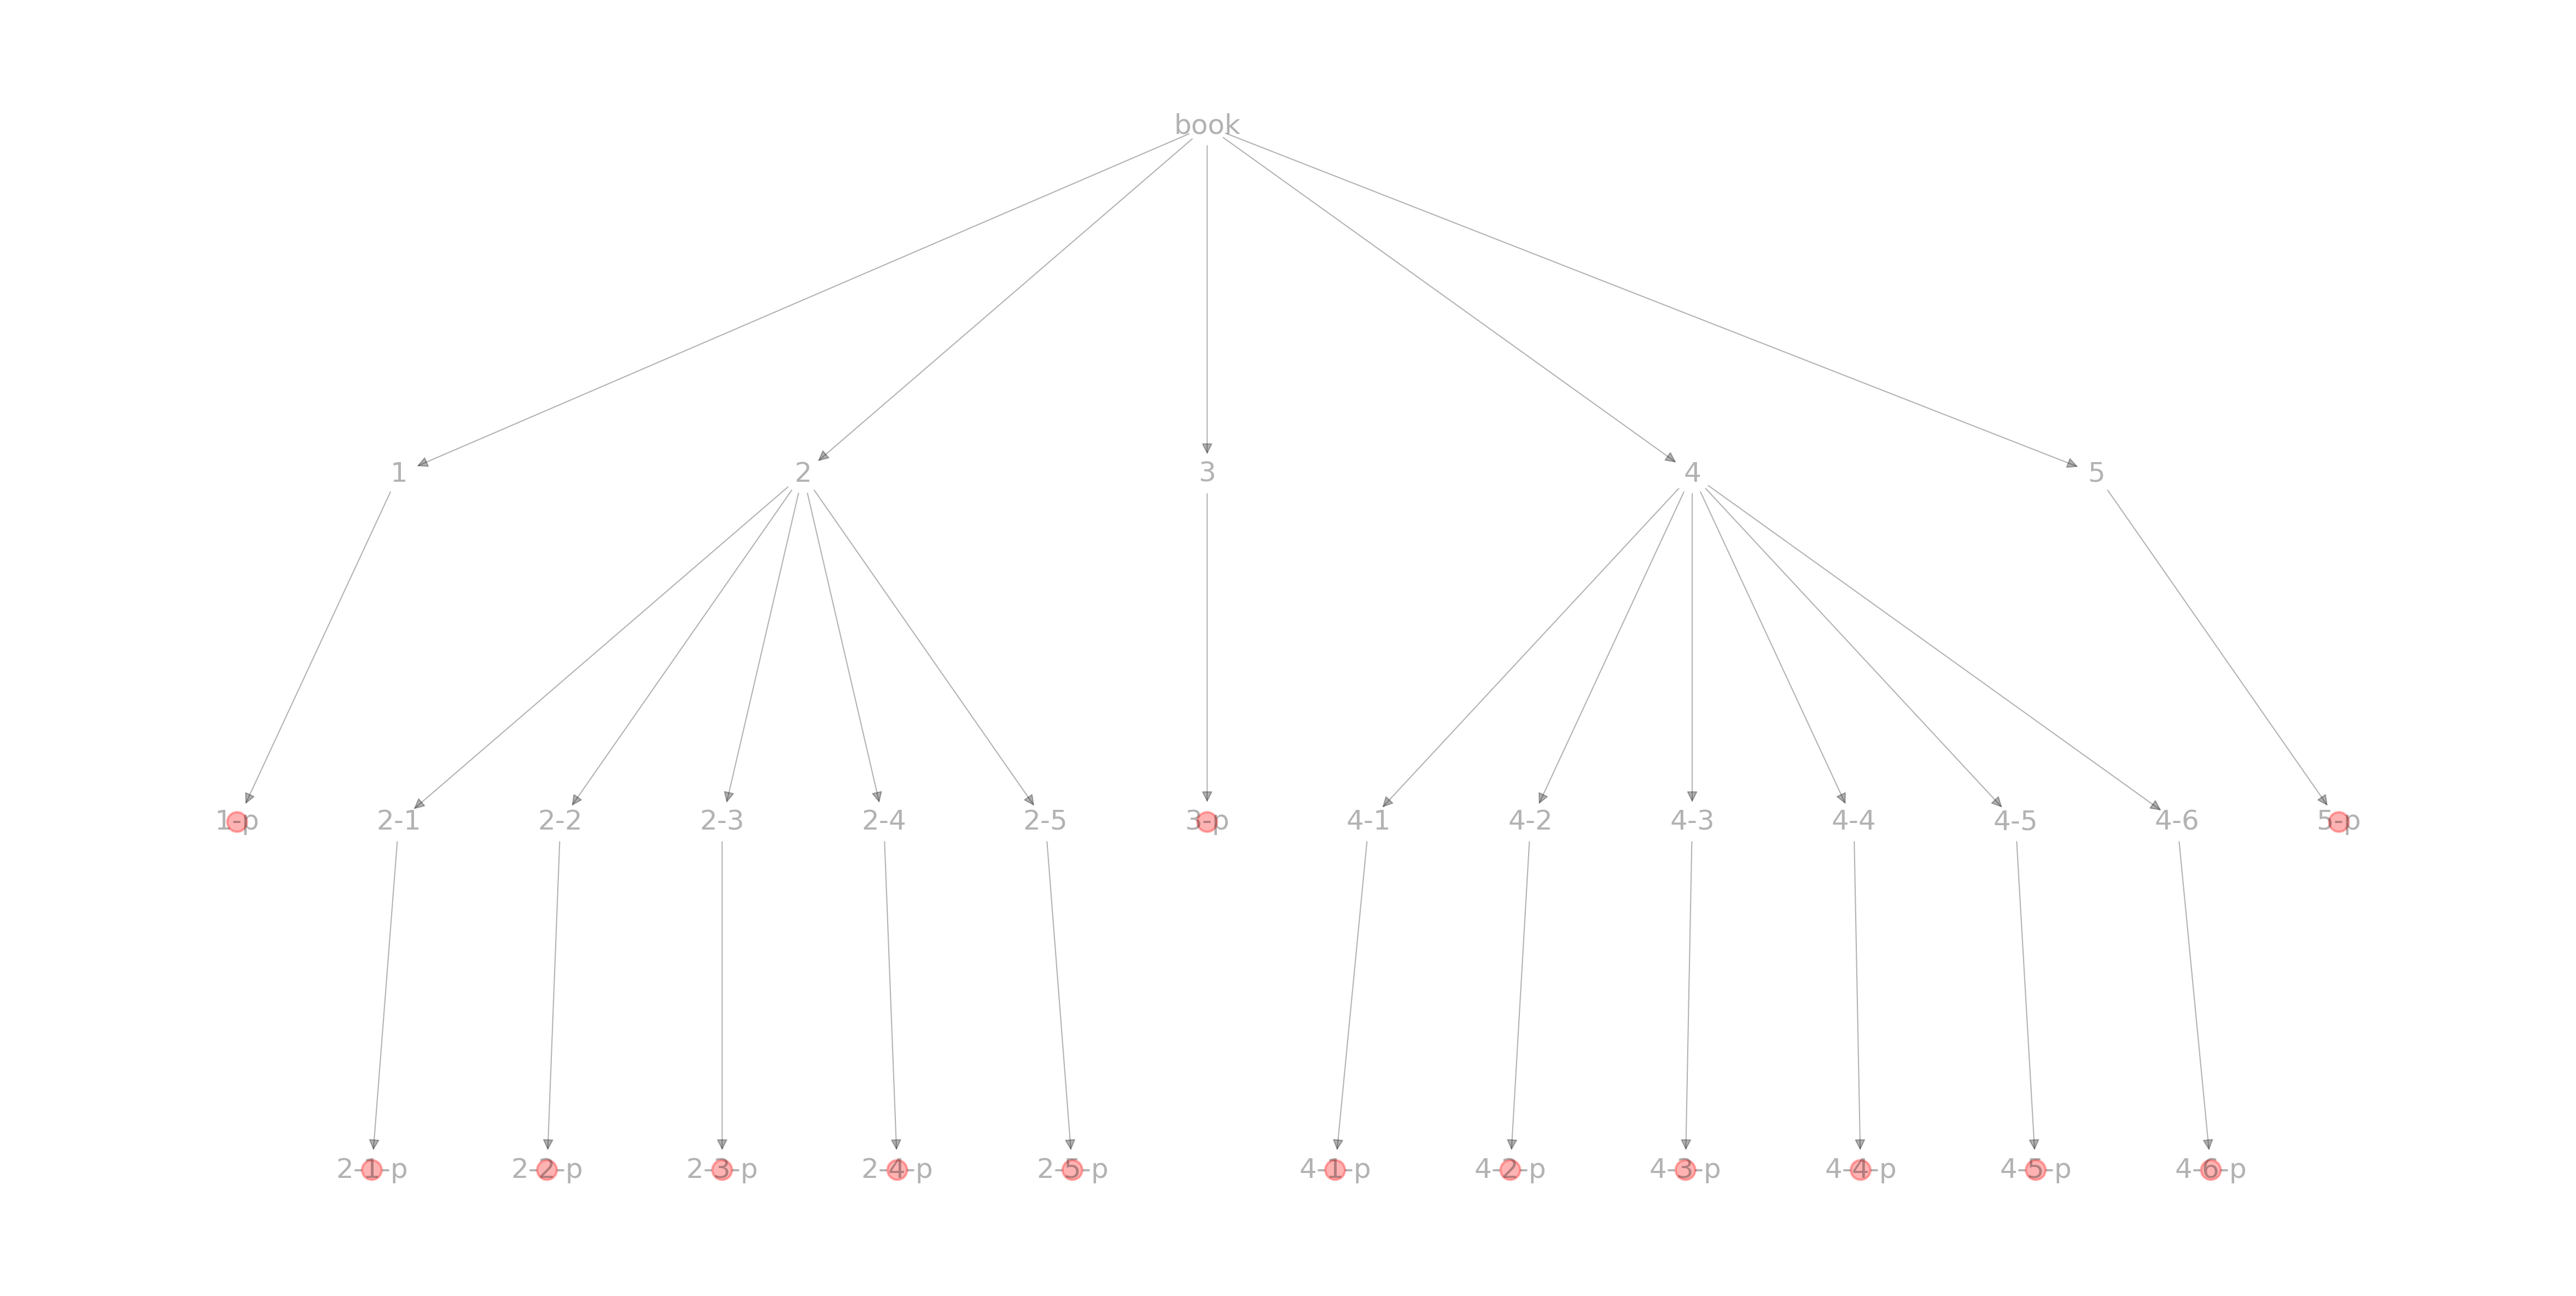

In [19]:
pos = graphviz_layout(book_graph, prog="dot")

# matplotlib settings
fig = plt.figure(figsize=(20, 10), dpi=300)
ax = fig.add_subplot(1, 1, 1)

# Color the leaf nodes (content nodes) in red
node_color_list = ["r" if "p" in s else "w" for s in list(book_graph.nodes)]

# draw the network
nx.draw(book_graph,
        ax=ax,
        pos=pos,
        with_labels=True,
        node_size=300,
        node_color=node_color_list,
        alpha=0.3,
        node_shape='.',
        width=0.5)

print("The arrows starting from 'book' represent chapters, with sections below them and subsections below the sections.\nThese nodes contain information such as the title and summary of each chapter or section.\nAdditionally, the end nodes marked in red circles hold information on the content of the text.")

## latexmkrc Generation

In [20]:
# Get the path of the home directory
home_dir = os.path.expanduser("~")

# Create the path for the .latexmkrc file
latexmkrc_path = os.path.join(home_dir, ".latexmkrc")

# Contents of the latexmkrc file
content = '''$latex = 'pdflatex -synctex=1 -halt-on-error -interaction=nonstopmode %O %S';
$bibtex = 'bibtex %O %S';
$biber = 'biber %O %S';
$makeindex = 'makeindex %O -o %D %S';
$dvipdf = 'dvipdfmx %O -o %D %S';

$max_repeat = 5;
$pdf_mode = 1;'''

# Create the file and write the content
try:
    with open(latexmkrc_path, "w") as file:
        file.write(content)
    print(f".latexmkrc file has been created successfully at {latexmkrc_path}")
except IOError as e:
    print(f"An error occurred while creating the file: {e}")

.latexmkrc file has been created successfully at /Users/hissain/.latexmkrc


## LaTeX Generation Styles Setting

In [21]:
geometry_options = {"tmargin": "3cm", "lmargin": "3cm"}
doc = Document(documentclass="report", geometry_options=geometry_options)

# Adding preamble and title
doc.packages.append(Package('amsmath'))
doc.packages.append(Package('amssymb'))
doc.packages.append(Package('amsfonts'))
doc.packages.append(Package('mathtools'))
doc.packages.append(Package('bm'))
doc.packages.append(Package('physics'))
doc.packages.append(Package('inputenc', options="utf8"))
doc.packages.append(Package('listings'))
doc.packages.append(Package('jvlisting'))
doc.packages.append(Package('color'))
doc.packages.append(Package('underscore', options="strings"))

# Adding title, author, and date to the preamble
doc.preamble.append(Command("title", book_graph.nodes[book_node_name]["title"]))
doc.preamble.append(Command("author", book_author))
doc.preamble.append(Command("date", NoEscape(r"\today")))

# Generating the title and table of contents
doc.append(NoEscape(r"\maketitle"))  # Generates the title with author and date
doc.append(NoEscape(r"\tableofcontents"))

# Setting up custom lstset for listings
doc.append(NoEscape(r'\lstset{backgroundcolor={\color[gray]{.90}}, breaklines=true, breakindent=10pt, basicstyle=\ttfamily\scriptsize, commentstyle={\itshape \color[cmyk]{1,0.4,1,0}}, classoffset=0, keywordstyle={\bfseries \color[cmyk]{0,1,0,0}}, stringstyle={\ttfamily \color[rgb]{0,0,1}}, frame=TBrl, framesep=5pt, numbers=left, stepnumber=1, numberstyle=\tiny, tabsize=4, captionpos=t}'))

In [22]:
# Arrange nodes containing the main text content in order
content_str_list = extract_content_list(list(book_graph.nodes))
sorted_content_str_list = sort_strings(content_str_list)

# Add main content
for heading_number_str in sorted_content_str_list:
    heading_number = custom_sort_key(heading_number_str)

    # Add chapter title
    if len(heading_number[1:]) == 0 or all(x == 1 for x in heading_number[1:]):
        node_name = "-".join(map(str, heading_number[0:1]))
        with doc.create(Chapter(book_graph.nodes[node_name]["title"], label=False)):
            doc.append(NoEscape(book_graph.nodes[node_name]["summary"].replace("\\\\","\\")))

    # Add section title
    if (len(heading_number[2:]) == 0 and len(heading_number[:2]) > 1) or (len(heading_number[2:]) > 0 and all(x == 1 for x in heading_number[2:])):
        node_name = "-".join(map(str, heading_number[0:2]))
        with doc.create(Section(book_graph.nodes[node_name]["title"], label=False)):
            doc.append(NoEscape(book_graph.nodes[node_name]["summary"].replace("\\\\","\\")))

    # Add subsection title
    if (len(heading_number[3:]) == 0 and len(heading_number[:3]) > 2) or (len(heading_number[3:]) > 0 and all(x == 1 for x in heading_number[3:])):
        node_name = "-".join(map(str, heading_number[0:3]))
        with doc.create(Subsection(book_graph.nodes[node_name]["title"], label=False)):
            doc.append(NoEscape(book_graph.nodes[node_name]["summary"].replace("\\\\","\\")))

    # Add main text content
    tex_file_path = book_graph.nodes[heading_number_str]["content_file_path"]
    try:
        with open(tex_file_path, "r", encoding='UTF-8') as file:
            tex_content = file.read()
            tex_content.replace('\&', '\\&')
            doc.append(NoEscape(tex_content))
    except Exception as e:
        print(e)

## PDF Generation

In [23]:
# Compilation. A file named /content/textbook.pdf will be created
n_displayed_line = 10
isErrorOccured = False

try:
    doc.generate_pdf(book_node["title"], compiler="latexmk", clean_tex=False)
except:
    log_file_path = book_node["title"] + ".log"

    # Read the contents of the log file
    with open(log_file_path, "r", encoding="utf-8", errors="ignore") as file:
        lines = file.readlines()

    # Define error output pattern (file-line-error option format)
    pattern = r'([a-zA-Z0-9_.]+):(\d+): (.+)'

    for i, line in enumerate(lines):
        match = re.search(pattern, line)
        if match:
            isErrorOccured = True
            print(f"Line: {match.group(2)}")
            print(f"Message: \n  {match.group(3)}")
            for j in range(i+1, min(i+n_displayed_line, len(lines))):
                print(lines[j].strip())
            print("-" * 40)

Latexmk: This is Latexmk, John Collins, 17 March 2019, version: 4.63b.
Rule 'pdflatex': The following rules & subrules became out-of-date:
      'pdflatex'
------------
Run number 1 of rule 'pdflatex'
------------
------------
Running 'pdflatex  --interaction=nonstopmode -recorder  "/Users/hissain/git/github/llmexp/books_prof/fallacy/Common Biases and Fallacies.tex"'
------------
Latexmk: applying rule 'pdflatex'...
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode

(/Users/hissain/git/github/llmexp/books_prof/fallacy/Common Biases and Fallacie
s.tex
LaTeX2e <2018-12-01>
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/report.cls
Document Class: report 2018/09/03 v1.4i Standard LaTeX document class
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/fontenc.sty
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/t1enc.def))
(/usr/

## Markdown Generation

In [24]:
def clean_markdown_content(content):
    # Remove the part before the first heading (LaTeX settings section)
    content = content.split('#', 1)[1]

    # Remove % only when it has whitespace before or after
    content = re.sub(r"(?<=\s)%|%(?=\s)", "", content)

    # Remove % only when it appears at the end of a line
    content = re.sub(r"%\s*$", "", content)

    # Replace multiple newlines with a single newline
    content = re.sub(r"\n{2,}", "\n\n", content)

    return content

def convert_to_latex_to_katex(content):
    # Convert align and align* environments
    content = re.sub(r'\\begin{align\*?}', r'$$\n\\begin{aligned}', content)
    content = re.sub(r'\\end{align\*?}', r'\\end{aligned}\n$$', content)

    # Convert equation and equation* environments
    content = re.sub(r'\\begin{equation\*?}', r'$$', content)
    content = re.sub(r'\\end{equation\*?}', r'$$', content)

    return content

def transform_code_blocks(content):

    # Extract and handle language option
    def replace_lstlisting(match):
        options = match.group(1)
        code = match.group(2)
        # Search for language option
        lang_match = re.search(r'language=([a-zA-Z]+)', options)
        lang = lang_match.group(1) if lang_match else ''
        # Convert to Markdown format
        return f'```{lang}\n{code}\n```'

    # Conversion process for lstlisting
    content = re.sub(r'\\begin{lstlisting}\[(.*?)\](.*?)\\end{lstlisting}', replace_lstlisting, content, flags=re.DOTALL)

    return content

In [25]:
# if md_output:
#     %pip install latex2markdown
#     import latex2markdown

#     with open(book_node["title"] + ".tex", "r") as f:
#         latex_string = f.read()

#     # Convert LaTeX to Markdown
#     processed_latex_str = transform_code_blocks(latex_string)
#     l2m = latex2markdown.LaTeX2Markdown(processed_latex_str)
#     markdown_string = l2m.to_markdown()

#     # Format the Markdown text
#     cleaned_md_str = clean_markdown_content(markdown_string)
#     katex_md_str = convert_to_latex_to_katex(cleaned_md_str)

#     with open(book_node["title"] + ".md", "w") as f:
#         f.write(katex_md_str)
#     files.download(book_node["title"] + ".md")